# 单发多框检测

现在有了锚框、边界框、多尺度目标检测和相关数据集，然后现在可以实现目标检测模型：单发多框检测的模型SSD。

下面实现的是Liu et al 于2016年提出的检测模型，该算法简单快速而且被广泛使用，而且它的设计原则和实现细节也被其它模型沿用。

## SSD
模型由基础网络组成，其后是几个多尺度特征块。基本网络用于从输入图像中提取特征。因此可以使用Deep CNN。SSD论文中选用了在分类层之前截断的VGG，现在常常使用ResNet分类层之前的全卷积块替代。可以设计基础网络使它输出的高和宽度较大。这样一来可以生成的锚框较多，可以用来检测尺寸较小的目标。每个多尺度特征块上面基于上一层的特征图将宽高缩小，从而将感受野变得更加广阔。

通过不同尺度的特征图，我们就可以检测不同尺度的物体，通过多尺度特征块，SSD检测生成不同大小的锚框，并通过预测边界框的类别和偏移量来预测大小不同的目标。

# 类别预测层
设目标类别的数量为$q$，锚框有$q+1$个类别，因为有一个是负类，在某个scale下设特征图的高和宽分别为$h,w$，其中每个单元生成$a$个锚框，我们需要对$hwa$个锚框进行分类。使用全连接层进行回归的话，参数会非常的多。解决方法是使用卷积层的通道来输出类别，SSD就是采用该方法来降低参数量的。

类别预测层使用一个保持输入高和宽的卷积层。这样一来输入和输出从坐标上是一一对应的，考虑输出和输入同一空间的坐标$(x,y)$，特征图上的$(x,y)$的坐标通道里面包含了以输入特征图$(x,y)$坐标为中心生成的所有锚框的类别预测。因此输出通道数就是$a(q+1)$，其中索引为$i(q+1) + j (0 \leq j \leq q)$的通道代表索引为i的锚框有关类别索引为j的预测。



In [89]:
# 定义一个类别预测层，通过参数num_anchors和num_classess分别指定a和q。该图层使用填充为1的3*3conv，输入和输出的宽度依然是保持不变。
%matplotlib inline
import torch as t
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
from pltutils import *

In [90]:
def cls_predictor(num_inputs:int,num_anchors:int,num_classess:int)->nn.Conv2d:
    """
    类别预测卷积层,使用3*3卷积和1的padding来保持输入输出的shape不变
    """
    return nn.Conv2d(num_inputs,num_anchors*(num_classess+1),kernel_size=3,padding=1)

In [91]:
# 边界框预测层与类别预测是类似的，不同的是我们需要输出4*num_anchors个输出而不是上面所谓的q+1个类别
def bbox_predictor(num_inputs,num_anchors):
    """
    边界框预测层，输出4*num_anchors个坐标，同样使用cls_predictor中的设置使输入输出的shape不变
    """
    return nn.Conv2d(num_inputs,num_anchors*4, kernel_size=3,padding=1)

# 连结多尺度的预测
在不同的尺度下，特征图的姓黄或者以同一单元为中心的锚框数量会不同，因此预测输出的形状也不同。

In [92]:
def forward(data:t.Tensor,block:nn.Module)->t.Tensor:
    return block.forward(data)

Y1 = forward(t.zeros((2,8,20,20)),cls_predictor(8,5,10))
Y2 = forward(t.zeros((2,16,10,10)),cls_predictor(16,3,10))
print("形状是[batch,num_achors*(num_classes+1),h,w]")
Y1.shape,Y2.shape


形状是[batch,num_achors*(num_classes+1),h,w]


(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [93]:
# 由于维度有不一样的尺寸，所以要进行reshape操作
# 首先将通道移到最后一维，因为在不同的尺度下批量大小仍然保持不变，所以可以将预测结果转成二维的
# [batch_size,h*w*num_channels]
def flatten_pred(pred:t.Tensor):
    return t.flatten(pred.permute(0,2,3,1),start_dim=1)

def concat_preds(preds:t.Tensor):
    return t.cat([flatten_pred(p) for p in preds],dim=1)

# 高宽减半
为了在多个尺度下面检测目标，需要进行特征图的下采样，沿用了VGG模块的设计。输出中的感受野为6

In [94]:
def down_sample_blk(in_channels,out_channels):
    """
    下采样块
    """
    blk=[]
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels= out_channels
    # 在这里将hw减半的
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [95]:
# TEST
down_sample_blk(3,10).forward(t.zeros((2,3,20,20))).shape
# 可以看到hw都减成原来的一半

torch.Size([2, 10, 10, 10])

# 基本网络块
基本网络块负责从原始输入图像中提取特特征。

为了简洁起见，我们使用3个宽和搞减半的块。并逐步地将通道数翻倍。

In [96]:
def base_net()->nn.Sequential:
    blk=[]
    num_filters =[3,16,32,64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i],num_filters[i+1]))
    return nn.Sequential(*blk)



In [97]:
base_net().forward(t.zeros((2,3,256,256))).shape

torch.Size([2, 64, 32, 32])

# 完整模型

In [98]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i ==1 :
        blk=down_sample_blk(64,128)
    elif i==4 :
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128,128)
    return blk

def blk_forward(X:t.Tensor,blk:nn.Module,size,ratio,cls_predictor,bbox_predictor):
    Y = blk.forward(X)
    anchors = multibox_prior(Y,sizes=size,ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y,anchors,cls_preds,bbox_preds)


一个较接近顶部的多尺度特征块是用于检测较大目标的，因此需要生成更大的锚框，在前向传播中我们调用multibox_prior函数的size参数传递两个比例值的列表

In [99]:
sizes = [[0.2,0.272],[0.37,0.447],[0.54,0.619],[0.71,0.79],[0.88,0.96]]
ratios = [[1,2,0.5]]*5 # 复制五次
num_anchors = len(sizes[0])+len(ratios[0])-1

In [100]:
class TinySSD(nn.Module):
    def __init__(self,num_classes,**kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64,128,128,128,128]

        for i in range(5):
            setattr(self,f"blk_{i}",get_blk(i))
            setattr(self,f"cls_{i}",cls_predictor(idx_to_in_channels[i],num_anchors,num_classes))
            setattr(self,f"bbox_{i}",bbox_predictor(idx_to_in_channels[i],num_anchors))
    
    def forward(self,X):
        anchors ,cls_preds,bbox_preds = [None]*5,[None]*5,[None]*5

        for i in range(5):
            X,anchors[i] ,cls_preds[i],bbox_preds[i] = blk_forward(X,
            getattr(self,f"blk_{i}"),sizes[i],ratios[i],
            getattr(self,f"cls_{i}"),getattr(self,f"bbox_{i}"))
        anchors = t.cat(anchors,dim=1)
        cls_preds = concat_preds(cls_preds)
        # 有个负类，所以需要加一
        cls_preds = cls_preds.reshape(cls_preds.shape[0],-1,self.num_classes+1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors,cls_preds,bbox_preds
    


In [101]:
net = TinySSD(1)
X = t.zeros((32,3,256,256))
anchors, cls_preds , bbox_preds = net.forward(X)

In [102]:
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)


output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


读取数据集

In [103]:
batch_size =32 
train_iter , _ = load_data_bananas(batch_size)


read1000training examples
read100validation samples


In [104]:
device , net = t.device("cuda:0") , TinySSD(1)
trainer = t.optim.SGD(net.parameters(),lr=0.2,weight_decay=5e-4,momentum=0.5)

定义损失函数和评价函数

In [105]:
cls_loss = nn.CrossEntropyLoss(reduction="none")
bbox_loss = nn.L1Loss(reduction="none")
# 除此之外nn.SmoothL1Loss()也可以用
# 对于bboxloss来说 focalloss 也是不错的

def cal_loss (cls_preds:t.Tensor,cls_labels:t.Tensor,bbox_preds:t.Tensor,bbox_labels:t.Tensor,bbox_masks:t.Tensor):
    batch_size ,num_classes = cls_preds.shape[0],cls_preds.shape[2]
    cls = cls_loss.forward(cls_preds.reshape(-1,num_classes),cls_labels.reshape(-1))
    cls = cls.reshape(batch_size,-1).mean(dim=1)
    bbox = bbox_loss.forward(bbox_preds*bbox_masks,bbox_labels*bbox_masks).mean(dim=1)
    return cls + bbox
    

可以沿用准确率来评价分类结果。使用MAE来评价边界框的预测结果。

In [106]:
def cls_eval(cls_preds:t.Tensor,cls_labels:t.Tensor):
    """
    由于类别预测结果放在最后一维,argmax需要指定最后一维。
    """
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype)==cls_labels).sum())

def bbox_eval(bbox_preds:t.Tensor,bbox_lables:t.Tensor,bbox_masks:t.Tensor):
    return float((t.abs((bbox_lables-bbox_preds)*bbox_masks)).sum())

训练模型

class err 3.19e-03, bbox mae 3.09e-03
4129.5 examples/sec on cuda:0


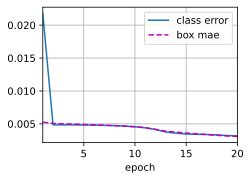

In [107]:
num_epochs,timer = 20, Timer()
animator = Animator(xlabel="epoch",xlim = [1,num_epochs],legend=["class error", 'box mae'])
net = net.to(device)

for epoch in range(num_epochs):
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X,Y = features.to(device),target.to(device)
        anchors,cls_preds,bbox_preds = net(X)
        bbox_labels, bbox_masks,cls_labels= multibox_target(anchors,Y)
        # 计算损失函数
        l = cal_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds,cls_labels),
        cls_labels.numel(),bbox_eval(bbox_preds,bbox_labels,bbox_masks),bbox_labels.numel())
        
    cls_err,bbox_mae = 1-metric[0]/metric[1],metric[2]/metric[3]
    animator.add(epoch+1,(cls_err,bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')


# 预测目标


In [108]:
def predict(X:t.Tensor):
    net.eval()
    anchors,cls_preds,bbox_preds = net.forward(X.to(device))
    cls_probs  = F.softmax(cls_preds,dim=2).permute(0,2,1)
    output = multibox_detection(cls_probs,bbox_preds,anchors)
    idx = [i for i,row in enumerate(output[0]) if row[0] != -1]
    return output[0,idx]

def display_img(img:t.Tensor,output:t.Tensor,threshold):
    set_figsize((5,5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1]) 
        if score<threshold:
            continue
        h,w = img.shape[0:2]
        bbox=[row[2:6] * t.tensor((w,h,w,h),device=row.device)]
        show_bboxes(fig.axes,bbox,'%.2f' % score, 'w')

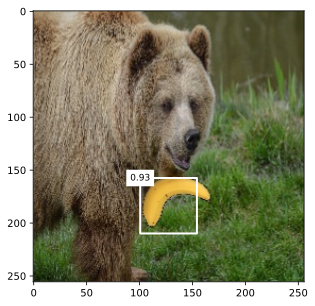

In [109]:
X = tv.io.read_image("../dataset/banana-detection/bananas_val/images/10.png").unsqueeze(0).float()
img = X.squeeze(0).permute(1,2,0).long()
output = predict(X)

display_img(img, output.cpu(), threshold=0.9)